[link](https://apps.skillfactory.ru/learning/course/course-v1:SkillFactory+DST-3.0+28FEB2021/block-v1:SkillFactory+DST-3.0+28FEB2021+type@sequential+block@ecdd7e4305d2452fa565e790906f9923/block-v1:SkillFactory+DST-3.0+28FEB2021+type@vertical+block@90a4ddddb7e2434194ac146e08bbeb8d)

Трудности могут возникнуть, если:

* нужно визуализировать результаты кластеризации, а пространство признаков многомерное.
* нужно обучить модель, а объект описывается большим количеством признаков. Эти признаки могут быть избыточными или малоинформативными, что приведёт к плохим результатам при обучении модели.

Избежать этих проблем поможет снижение размерности данных.

→ Мы встречались с уменьшением размерности ранее, например когда рассматривали спектральную кластеризацию. В данном юните мы поближе познакомимся с тем, как работают алгоритмы снижения размерности, рассмотрим такие техники, как PCA и t-SNE.

Задача снижения размерности — это задача преобразования данных с целью уменьшения количества признаков, которые описывают объект.

Методы снижения размерности могут преобразовывать данные двумя способами:

* линейно,
* нелинейно.

# PCA

Метод главных компонент, или PCA (Principal Components Analysis) — это один из базовых способов уменьшения размерности.

Данный метод имеет широкое применение:

* Подавление шума на изображениях.

Изображение состоит из пикселей, которые можно рассматривать как набор точек в многомерном пространстве. С помощью метода снижения размерности PCA можно преобразовать этот набор точек и оставить только первые компоненты, полученные после преобразования. В этих компонентах будет содержаться основная информация об изображении, но не будет шума. Таким образом мы улучшим качество изображения.

* Индексация видео для быстрого поиска по базе.

Каждый кадр видео можно преобразовать с помощью PCA и представить несколькими значениями. Далее эти значения легко хранить и искать в базе.

Для уменьшения размерности метод главных компонент проводит линейное преобразование пространства, которое сохраняет длины векторов. Таким образом происходит отображение признаков в новое пространство с меньшей размерностью.

В новом пространстве появляются новые оси. Они строятся таким образом, что для первой оси дисперсия данных должна быть максимальной, а вторая ось ортогональна первой и имеет максимально возможную дисперсию.

Первой главной компонентой будет называться первая ось в новом пространстве.

In [ ]:
# из модуля decomposition библиотеки sklearn импортируем класс PCA
from sklearn.decomposition import PCA
# создаём объект класса PCA
# n_components — задаём количество компонентов для проведения трансформации
pca = PCA(n_components=2, random_state=42)
# обучаем модель на данных X
pca.fit(X)
# применяем уменьшение размерности к матрице X
pca.transform(X)

# Также мы можем сразу обучить модель и применить трансформацию уменьшения размерности:

pca.fit_transform(X)

Для данного датасета обучим модель, которая по пикселям изображения предсказывает, что за цифра на нём изображена. Первой мы разработаем модель, которая будет учитывать все признаки, а затем уменьшим размерность данных с помощью PCA и ещё раз обучим модель. Далее мы сравним качество полученных моделей и время, которое было затрачено на обучение в каждом случае.

В датасете MNIST представлено 70 000 изображений, каждое из которых описывается 784 признаками.

In [2]:
# загрузим датасет MNIST
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

dataset = fetch_openml("mnist_784")
# загрузим признаки в переменную X  
X = dataset['data']
# загрузим «ответы» в переменную y
y = dataset['target']
# разделим данные с помощью sklearn на данные для обучения и теста
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=0)

# импортируем StandardScaler для стандартизации данных
from sklearn.preprocessing import StandardScaler

# создадим объект класса StandardScaler
scaler = StandardScaler()
scaler.fit(train_x)
# трансформируем датасеты train_x и test_x
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

# импортируем класс PCA
from sklearn.decomposition import PCA

# создадим объект класса PCA
pca = PCA(n_components=300)
pca.fit(train_x)
# уменьшим размерность данных
train_x_pca = pca.transform(train_x)
test_x_pca = pca.transform(test_x)

d:\Program Files\Python311\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Посмотрим, сколько признаков описывало объект до и после уменьшения размерности. Как мы можем заметить, сначала было 787 признаков, а в конце объект описывают уже 300 главных компонент:

In [3]:
print(len(train_x[0]))
print(len(train_x_pca[0]))

784
300


Обучим модель логистической регрессии, которая на вход будет принимать пиксели изображения и предсказывать, что на нём нарисовано.

Напишем функцию, которая будет принимать на вход данные для обучения (матрицу с признаками и правильные ответы) и данные для тестирования модели, а на выходе будет возвращать время, затраченное на обучение модели, и качество модели. В качестве метрики оценивания качества будем использовать метрику accuracy.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from time import time

# напишем функцию, которая на вход принимает X и y, а возвращает модель и время
def get_time_and_accuracy(train_x, train_y, test_x, test_y):
    # создадим объект класса LogisticRegression
    log_reg_model = LogisticRegression(max_iter=1000)
    # запишем время с начала эпохи в секундах до обучения модели
    start_time = time()
    # обучим модель
    log_reg_model.fit(train_x, train_y)    
    # запишем время с начала эпохи в секундах после обучения
    end_time = time()
    # подсчитаем время, потраченное на обучение модели
    delta_time = end_time-start_time
    # предскажем на тестовых данных
    y_pred = log_reg_model.predict(test_x)
    # посчитаем скор для тестового предсказания
    score = accuracy_score(test_y, y_pred)
    # вернём время, потраченное на обучение, и качество полученной модели
    return delta_time, score

model_pca_time, model_pca_acc = get_time_and_accuracy(train_x_pca, train_y, test_x_pca, test_y)
print(f"Модель, построенная на признаках, полученных после уменьшения размерности. Время обучения {model_pca_time}, метрика модели {model_pca_acc}")
# Модель, построенная на признаках, полученных после уменьшения размерности. Время обучения 54.12072825431824, метрика модели 0.9255714285714286

model_time, model_acc = get_time_and_accuracy(train_x, train_y, test_x, test_y)
print(f"Модель, построенная на всех исходных признаках. Время обучения {model_time}, метрика модели {model_acc}")
# Модель, построенная на всех исходных признаках. Время обучения 108.04033303260803, метрика модели 0.9187142857142857


Модель, построенная на признаках, полученных после уменьшения размерности. Время обучения 80.13398337364197, метрика модели 0.9254285714285714
Модель, построенная на всех исходных признаках. Время обучения 172.9748842716217, метрика модели 0.9187142857142857


Как видим, в данном случае мы потратили на обучение модели в два раза меньше времени, а качество осталось практически таким же.

В реальной работе бывает гораздо больше данных и на обучение модели уходит отнюдь не две минуты. Таким образом, применив технику уменьшения размерности, можно существенно сэкономить время.

# T-SNE

Для того чтобы визуализировать многомерное пространство признаков, необходимо уменьшить его размерность до двухмерного или трёхмерного. В этом поможет t-SNE (t-distributed Stochastic Neighbor Embedding), что переводится с английского как «стохастическое вложение соседей с t-распределением». 

t-SNE, в отличие от PCA, использует технику нелинейного снижения размерности данных. Обычно используется снижение размерности многомерного пространства до двух- или трёхмерного с целью дальнейшей визуализации. При преобразовании похожие объекты оказываются рядом, а непохожие — далеко друг от друга.

Рассмотрим t-SNE на примере понижения размерности двухмерного пространства до одномерного.

1. В исходном многомерном пространстве для каждого объекта из датасета рассчитываем евклидово расстояние между объектами. Далее с помощью нормального распределения попарно сравниваем объекты датасета. На основе этих значений строится матрица, которая содержит значения схожести объектов:

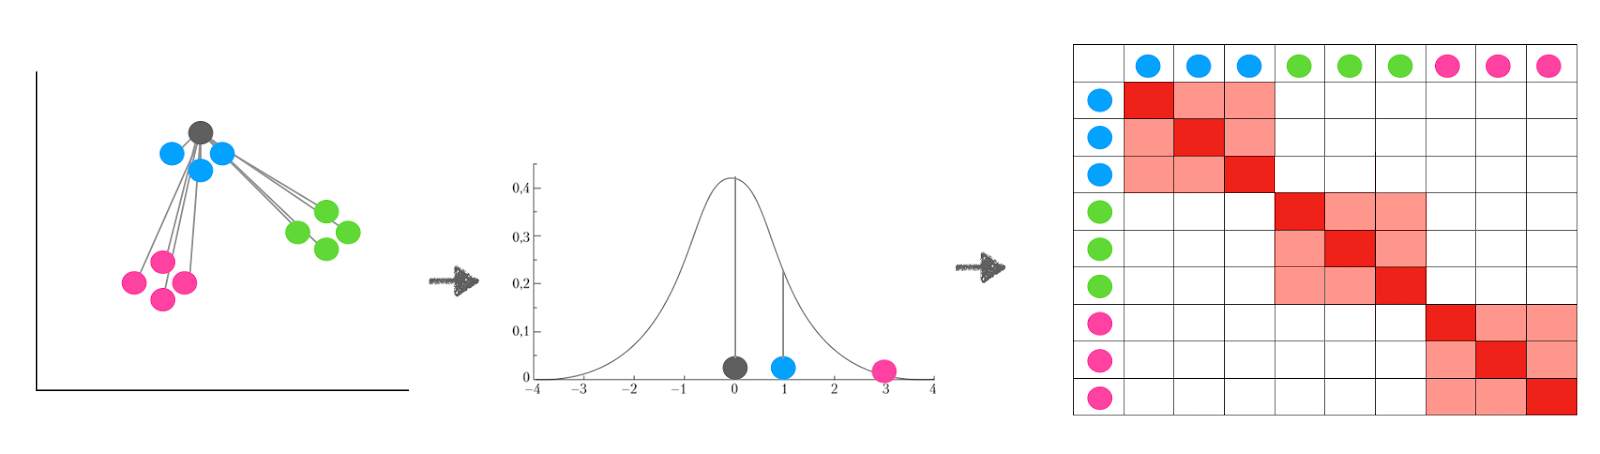

На рисунке выше показано, как для одной точки рассчитали расстояние до всех других точек датасета, далее получили схожесть объектов с помощью нормального распределения и построили матрицу. На данной матрице по строкам и столбцам находятся объекты датасета, а в ячейках — значения схожести двух объектов. Красным обозначена похожесть объекта на самого себя (в таком случае это значение максимально), а розовым — объекты, которые имеют большую схожесть.

2. На втором шаге мы уменьшаем размерность данных. Здесь мы случайным образом проецируем объекты из двухмерного пространства на ось x. Далее, как и на первом шаге, мы считаем схожесть объектов в новом пространстве, но для подсчёта используем не нормальное распределение, а t-распределение. После этого строим матрицу попарной схожести объектов:

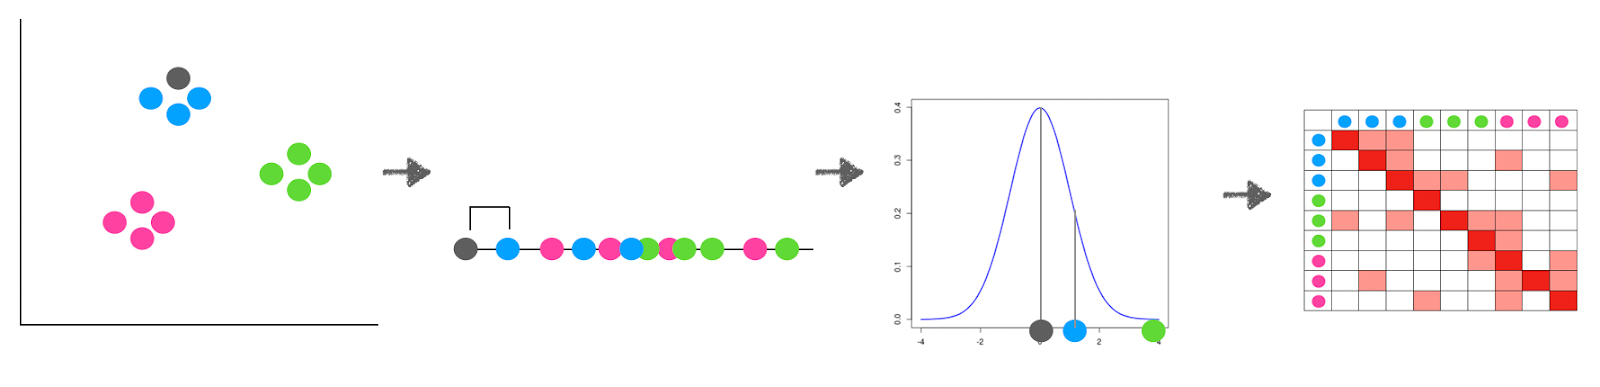

3. Далее необходимо создать новую матрицу сходства, которая будет похожа на исходную:

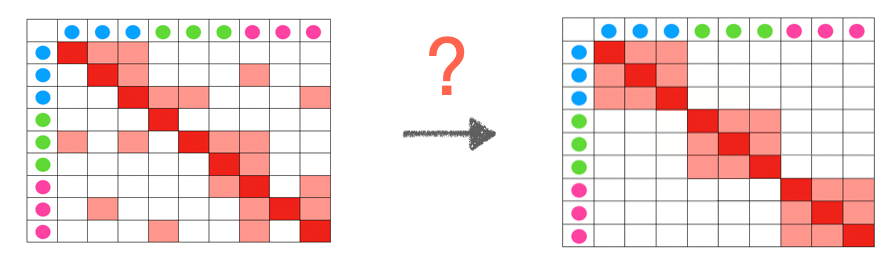

С каждой итерацией точки перемещаются к своим ближайшим соседям из исходного многомерного пространства и удаляются от отдалённых:

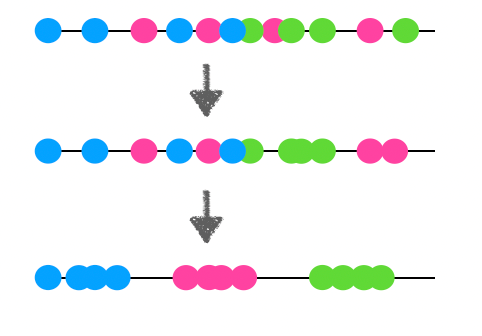

Таким образом, мы итеративно приходим к разделению объектов в новом пространстве.

## КАК ЗАПУСТИТЬ T-SNE?

In [5]:
# импортируем класс TSNE из модуля manifold библиотеки sklearn
from sklearn.manifold import TSNE

# создаём объект класса TSNE
# n_components — размерность нового пространства
tsne = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)
# обучаем модель на данных X и производим трансформацию
tsne.fit_transform(X)

array([[ 1.5667064e+01,  2.5798079e-02],
       [ 3.1374992e+01, -1.8581591e+01],
       [ 1.7242271e+01,  3.7437672e+01],
       ...,
       [ 4.1888819e+00,  2.0235611e+01],
       [ 1.0312383e+01,  1.1741742e+01],
       [ 2.9236069e+01,  1.6515596e+01]], dtype=float32)

Важные параметры для запуска:

* n_components — размерность нового пространства.
* perplexity — один из важнейших параметров для запуска. Этот параметр описывает ожидаемую плотность вокруг точки. Таким образом мы можем устанавливать соотношение ближайших соседей к точке. Если датасет большой, стоит установить большее значение * perplexity. Обычно используют значения в диапазоне от 5 до 50.
* n_iter — количество итераций для оптимизации.
* random_state — так как в алгоритме есть случайность, задание random_state позволяет от запуска к запуску получать одинаковые результаты.

Теперь попробуем уменьшить размерность и визуализировать пространство пикселей, которые описывают данные рукописного начертания цифр. Сравним, какая визуализация получается при использовании PCA и tSNE.

<AxesSubplot: xlabel='0', ylabel='1'>

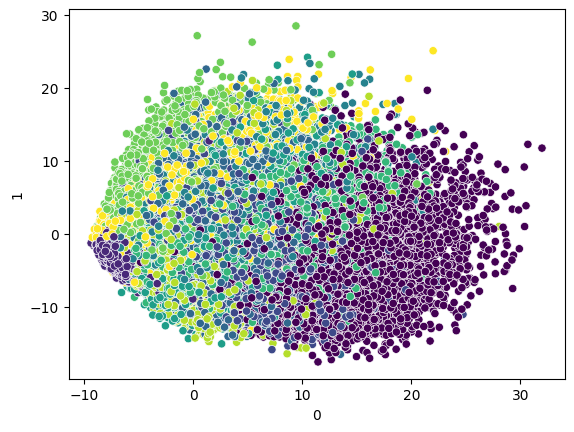

In [7]:
#Уменьшим размерность с помощью PCA:

import seaborn as sns
import pandas as pd

# создадим объект класса PCA, уменьшим размерность данных до 2
pca = PCA(n_components=2, random_state=42)
# уменьшим размерность данных
X_reduced = pca.fit_transform(train_x)
# сохраним данные в датафрейм
df_pca = pd.DataFrame(X_reduced)
# сохраним разметки кластеров
df_pca['c'] = pd.to_numeric(train_y).astype('Int64').to_list()
# визуализируем
sns.scatterplot(x=df_pca[0], y=df_pca[1], c=df_pca['c'])

<AxesSubplot: xlabel='0', ylabel='1'>

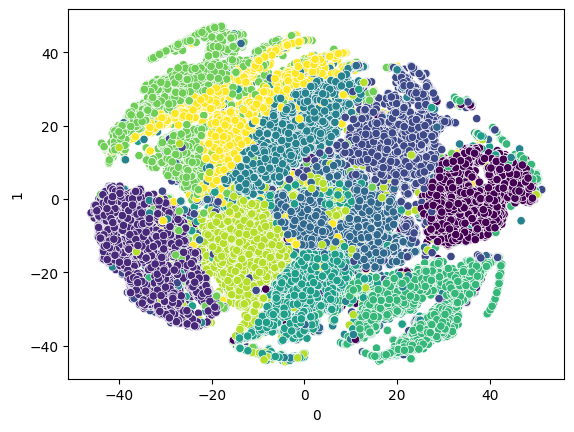

In [8]:
#Уменьшим размерность с помощью t-SNE:

# создадим объект класса TSNE, уменьшим размерность данных до 2
tsne = TSNE(n_components=2, perplexity=50, n_iter=500, random_state=42)
# уменьшим размерность данных
X_reduced = tsne.fit_transform(train_x)
# сохраним данные в датафрейм
df_tsne = pd.DataFrame(X_reduced)
# сохраним разметки кластеров
df_tsne['c'] = pd.to_numeric(train_y).astype('Int64').to_list()# визуализируем
sns.scatterplot(x=df_tsne[0], y=df_tsne[1], c=df_tsne['c'])

Как видим, алгоритм t-SNE отлично справляется с уменьшением размерности для визуализации, а вот при использовании PCA данные не разделились на кластеры и пересекаются друг с другом — такую визуализацию будет неудобно анализировать.

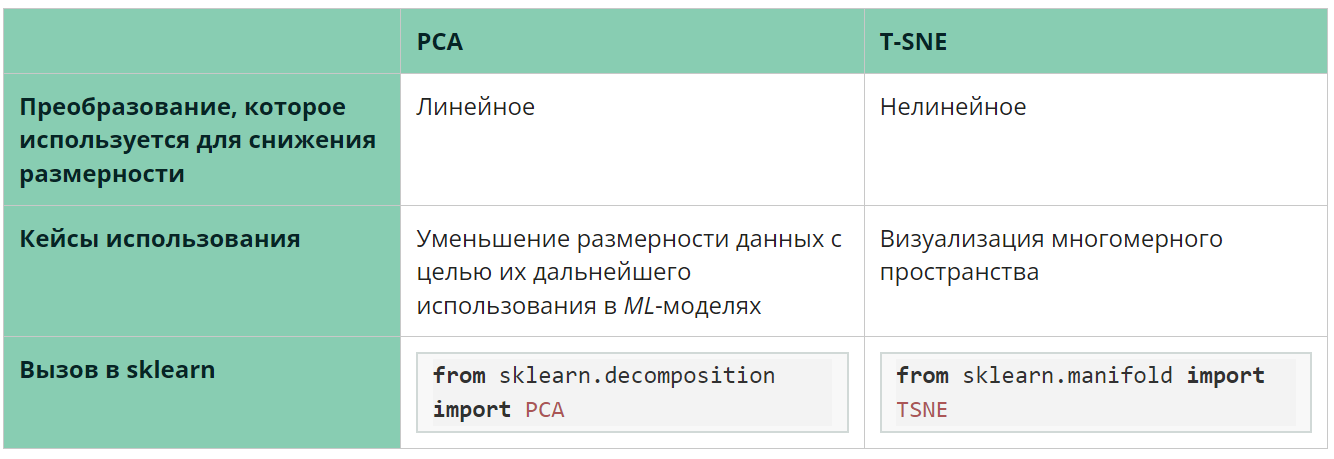

 PCA использует линейные преобразования.
 
t-SNE используется преимущественно для визуализации.

Совпадают ли в t-SNE матрицы с попарной схожестью объектов, одна из которых получена в исходном многомерном пространстве, а другая — в только что образовавшемся новом пространстве?

Нет. Суть алгоритма t-SNE состоит в том, чтобы итеративно прийти к совпадению матриц.